In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_contour, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_variable_histogram, plot_income_groups

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

# Read in often used values from config
with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
elif config['availability_function'] == 'combined_exponential':
    avail_func = None
else:
    raise ValueError('Availability function not recognized')

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

# Read in income groups from World Bank data
income_groups = pd.read_excel(config['world_bank_income_groups_file'])
income_groups = income_groups[['Code', 'Income group']]

In [3]:
def exposure_new(cdd, gdp):
    if avail_func is not None:
        return exposure_function((cdd, gdp), avail_func, params['cdd_scale'], params['alpha'], params['k'])
    else:
        return exposure_combined_exponential((cdd, gdp), params['cdd_scale'], params['alpha'], params['k'])

In [4]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Cooling deficit Index analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')

    # Formatting
    # Drop rows where year past is NaN
    ac_data = ac_data.dropna(subset=['Year_past'])
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)
    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']
    ac_data['ac_adoption'] = 1. - exposure_new(ac_data['CDD'], ac_data['GDP'])

    # Sort by income quantile and label each country with income group
    ac_data = pd.merge(ac_data, income_groups, left_on='ISO3', right_on='Code', how='left').rename(columns={'Income group': 'income_group'})
    # Drop Code
    ac_data = ac_data.drop(columns=['Code'])
    # Income group names drop 'income' and make lower
    ac_data['income_group'] = ac_data['income_group'].str.replace(' income', '').str.lower()
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)

    # Write full dataframe to csv
    if not os.path.exists(outfile_path):
        ac_data.to_csv(outfile_path)
    
    print(ac_data)



INFO:root:Cooling deficit Index analysis results not found, recalculating
INFO:root:No data for AFG in 1990
INFO:root:Found data for AFG in 2002
INFO:root:No data for AND in 1990
INFO:root:No data for AND in any year
INFO:root:No data for ASM in 1990
INFO:root:No data for ASM in any year
INFO:root:No data for BIH in 1990
INFO:root:Found data for BIH in 1994
INFO:root:No data for CHI in 1990
INFO:root:No data for CHI in any year
INFO:root:No data for CUB in 1990
INFO:root:No data for CUB in any year
INFO:root:No data for CUW in 1990
INFO:root:Found data for CUW in 2000
INFO:root:No data for CYM in 1990
INFO:root:Found data for CYM in 2006
INFO:root:No data for DJI in 1990
INFO:root:Found data for DJI in 2013
INFO:root:No data for ERI in 1990
INFO:root:No data for ERI in any year
INFO:root:No data for EST in 1990
INFO:root:Found data for EST in 1995
INFO:root:No data for FRO in 1990
INFO:root:No data for FRO in any year
INFO:root:No data for GIB in 1990
INFO:root:No data for GIB in any y

    ISO3         Country         CDD  Year_ref  Year_past     GDP_past  \
0    AFG     Afghanistan   876.75506      2019       2002  1280.463171   
1    ALB         Albania   630.35247      2019       1990  4827.027705   
2    DZA         Algeria  1231.21753      2019       1990  8828.874473   
3    ASM  American Samoa  3369.90188      2019       1990          NaN   
4    AGO          Angola  2169.94281      2019       1990  5793.084512   
..   ...             ...         ...       ...        ...          ...   
203  VNM        Viet Nam  3034.63204      2019       1990  2099.394649   
204  WSM   Western Samoa  3105.88948      2019       1990  3655.951872   
205  YEM           Yemen  2152.03753      2019       1990          NaN   
206  ZMB          Zambia  1596.08778      2019       1990  2290.039226   
207  ZWE        Zimbabwe  1442.73567      2019       1990  2704.757299   

              GDP  gdp_historical_growth  CDD_ssp1_rcp26_2100  \
0     2079.921861               0.028947      

In [5]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3', 'Country']).dropna()
print(ac_data_income_group)
ac_data_income_group = ac_data_income_group.groupby('income_group').median()

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    ac_data_income_group = calculate_gdp_const(ac_data_income_group, config, params)


# Add column to ac_data for GDP needed to get everyone to the exposure times cdd of the high income group
ac_data = calculate_gdp_const(ac_data, config, params, exp_cdd=ac_data_income_group.loc['high', 'exposure_times_cdd'])

INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([71, 82], dtype='int64'), possibly 0 CDD
INFO:r

            CDD  Year_ref  Year_past      GDP_past           GDP  \
0     876.75506      2019       2002   1280.463171   2079.921861   
1     630.35247      2019       1990   4827.027705  13653.182207   
2    1231.21753      2019       1990   8828.874473  11627.279918   
6     850.95843      2019       1990  14136.525401  22071.748100   
7     367.09430      2019       1990   5153.298211  14317.552869   
..          ...       ...        ...           ...           ...   
201  1080.56806      2019       1990   3638.876840   7403.742780   
203  3034.63204      2019       1990   2099.394649  10252.004622   
204  3105.88948      2019       1990   3655.951872   6346.256341   
206  1596.08778      2019       1990   2290.039226   3372.358980   
207  1442.73567      2019       1990   2704.757299   2203.396810   

     gdp_historical_growth  CDD_ssp1_rcp26_2100  CDD_ssp2_rcp45_2100  \
0                 0.028947               1078.0               1346.0   
1                 0.036504             

In [6]:
# Print GDP of income groups
print(ac_data_income_group[['GDP']])
# Get the color on the GDP map for each income group in RGB
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = plt.cm.get_cmap(config['plotting']['gdp_cmap'])
norm = mcolors.LogNorm(vmin=config['plotting']['gdp_min'], vmax=config['plotting']['gdp_max'])
ac_data_income_group['gdp_color'] = ac_data_income_group['GDP'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x))))
print(ac_data_income_group['gdp_color'])

                       GDP
income_group              
high          42739.049912
low            1773.188177
lower middle   5398.094415
upper middle  14990.931063
income_group
high            #84d44b
low             #472c7a
lower middle    #2d708e
upper middle    #21a585
Name: gdp_color, dtype: object


In [7]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']
# Print gdp_const_ssp2_rcp45_custom_exp_cdd divided by gdp_const_ssp2_rcp45 for low income group and compute its mean
growth_ratio = ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd']/ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45']
print('GDP growth ratio for low income group: {}'.format(growth_ratio.mean()))

GDP growth ratio for low income group: 1.8725952267696748


In [8]:
# print(ac_data[ac_data['GDP_past'] > ac_data['GDP']])
# print when future CDD is less than past CDD
print(ac_data[ac_data['CDD_ssp1_rcp26_2100'] < ac_data['CDD']])
# print(ac_data[ac_data['gdp_const_ssp1_rcp26']<0])


    ISO3           Country         CDD  Year_ref  Year_past      GDP_past  \
4    AGO            Angola  2169.94281      2019       1990   5793.084512   
9    AUS         Australia   790.79296      2019       1990  31006.100227   
37   CHL             Chile   175.72575      2019       1990   9701.823791   
39   COM           Comoros  2996.85716      2019       1990   2922.712252   
55   SLV       El Salvador  3111.70808      2019       1990   5191.971455   
61   FJI              Fiji  2627.50087      2019       1990   7889.878586   
64   PYF  French Polynesia  2827.62285      2019       1990           NaN   
71   GRL         Greenland     0.00023      2019       1990           NaN   
91   JAM           Jamaica  3097.91909      2019       1990   8692.502235   
95   KEN             Kenya  1471.73062      2019       1990   3655.362057   
100  KGZ        Kyrgyzstan   252.31133      2019       1990   5158.317569   
103  LBN           Lebanon  1056.62027      2019       1990   5855.805213   

/Users/aliciawongel/Work/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/aliciawongel/Work/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/aliciawongel/Work/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/dow

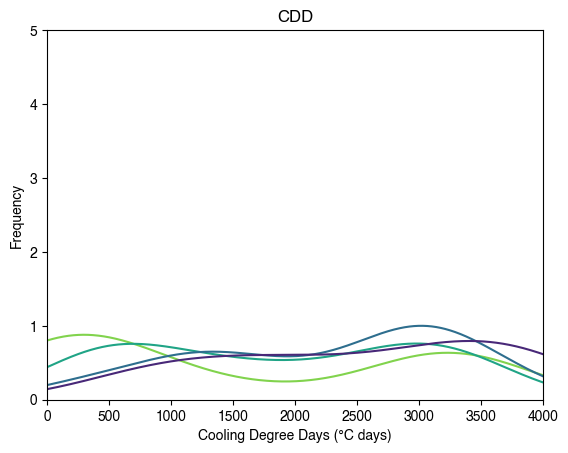

<Figure size 640x480 with 0 Axes>

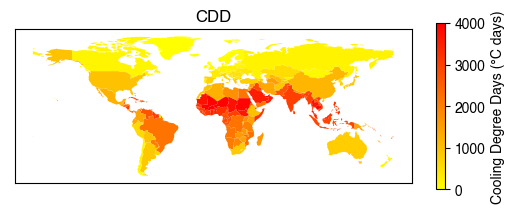

<Figure size 640x480 with 0 Axes>

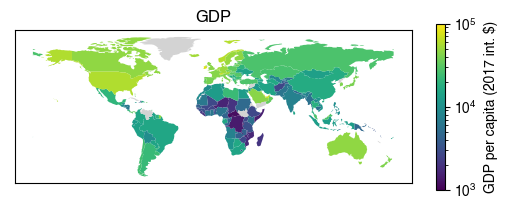

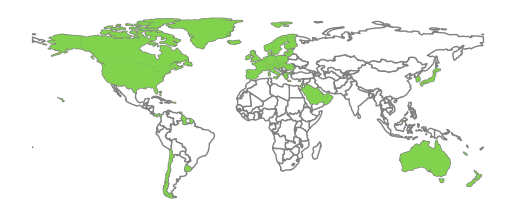

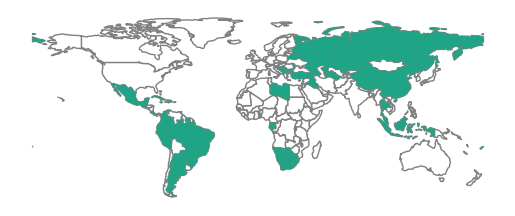

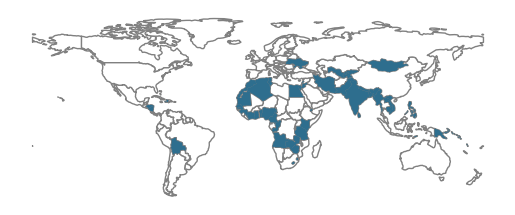

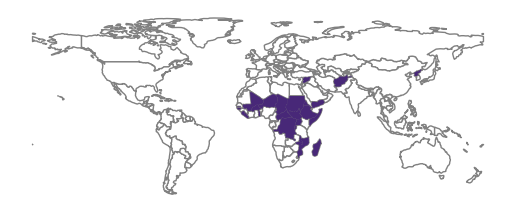

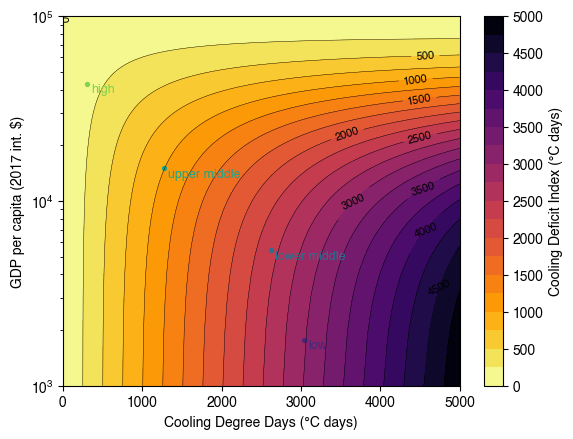

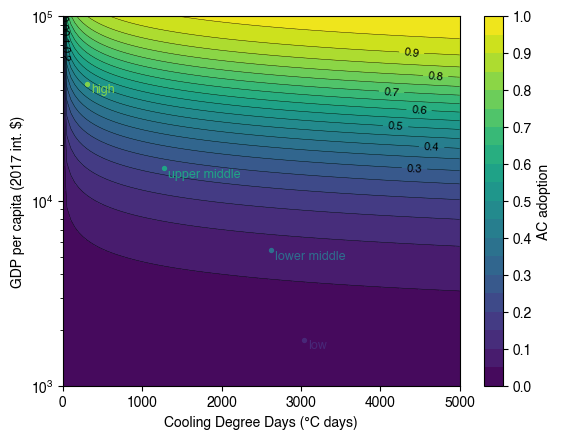

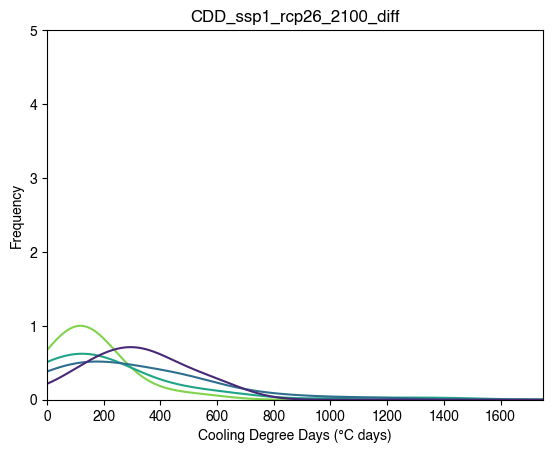

<Figure size 640x480 with 0 Axes>

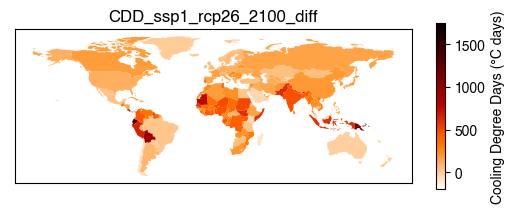

<Figure size 640x480 with 0 Axes>

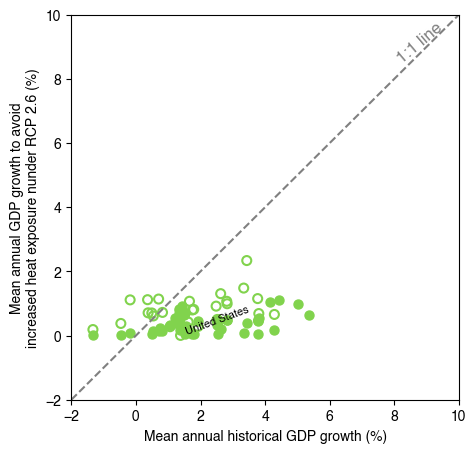

<Figure size 640x480 with 0 Axes>

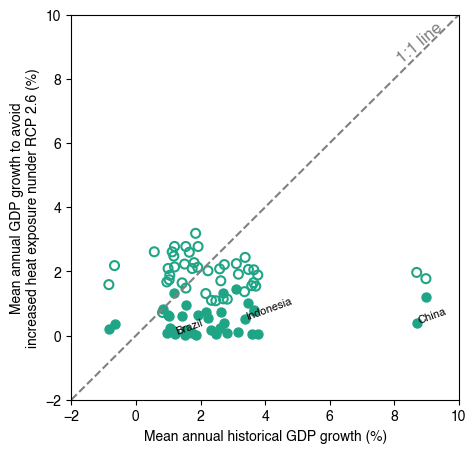

<Figure size 640x480 with 0 Axes>

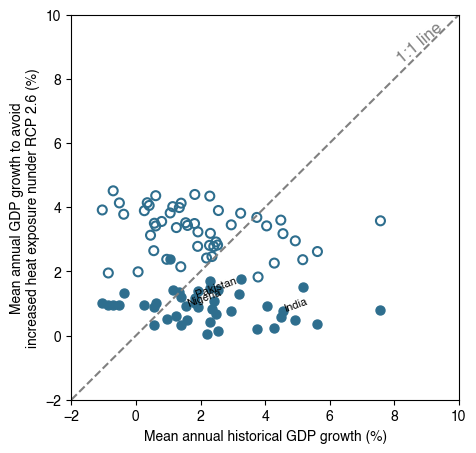

<Figure size 640x480 with 0 Axes>

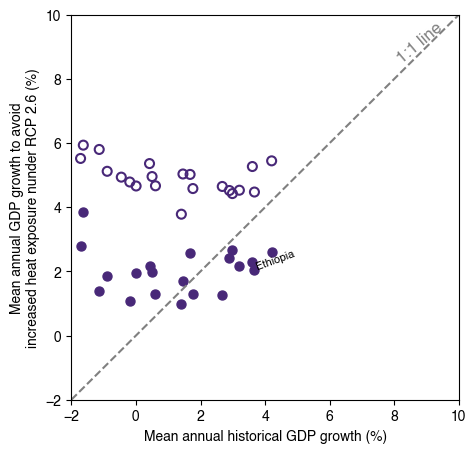

<Figure size 640x480 with 0 Axes>

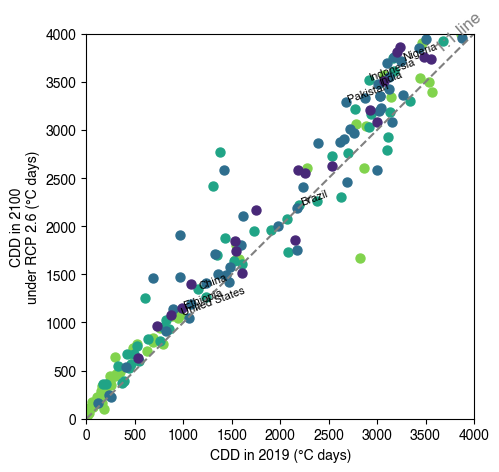

<Figure size 640x480 with 0 Axes>

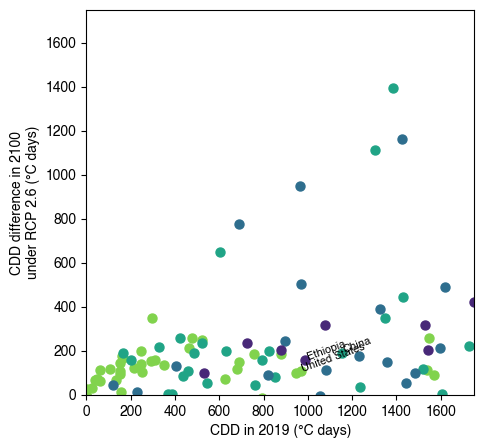

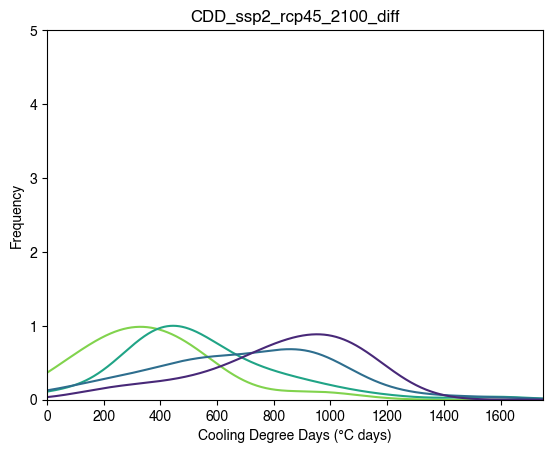

<Figure size 640x480 with 0 Axes>

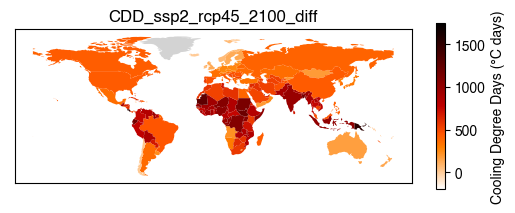

<Figure size 640x480 with 0 Axes>

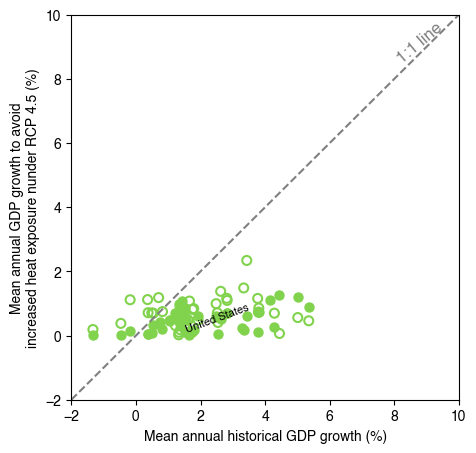

<Figure size 640x480 with 0 Axes>

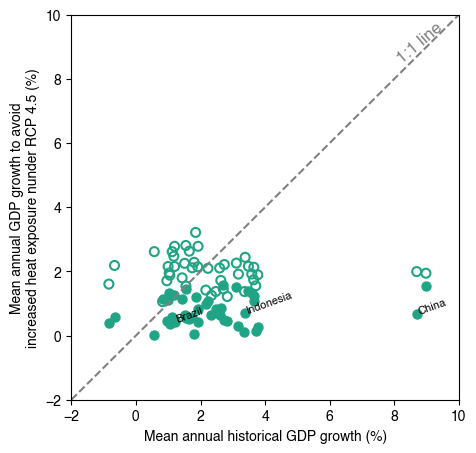

<Figure size 640x480 with 0 Axes>

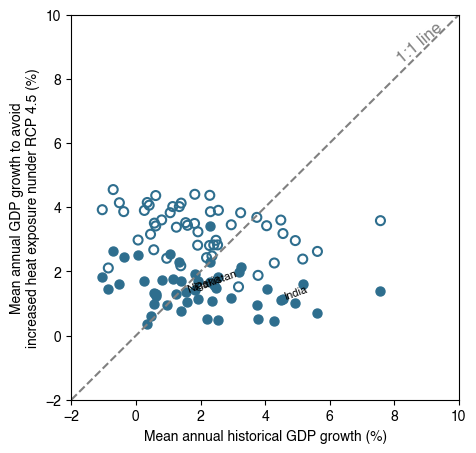

<Figure size 640x480 with 0 Axes>

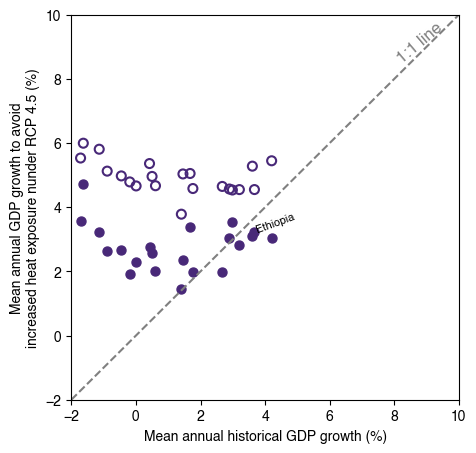

<Figure size 640x480 with 0 Axes>

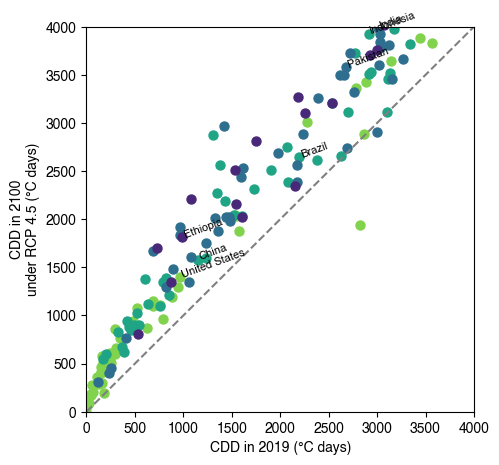

<Figure size 640x480 with 0 Axes>

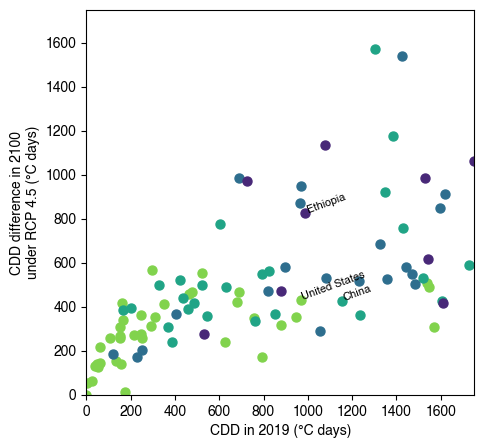

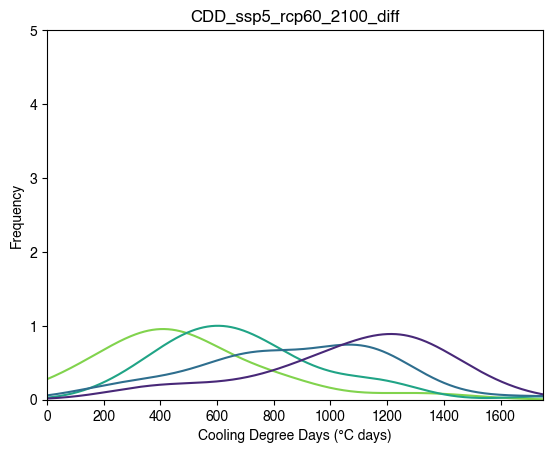

<Figure size 640x480 with 0 Axes>

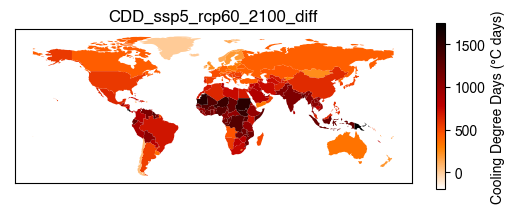

<Figure size 640x480 with 0 Axes>

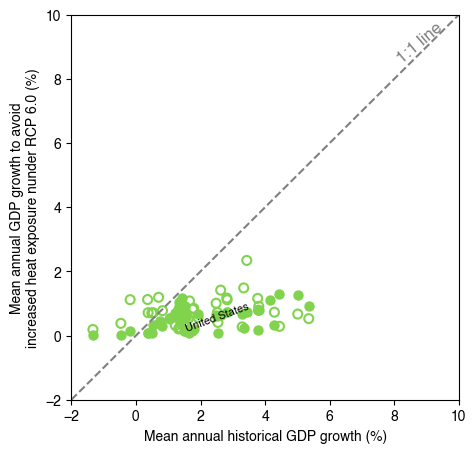

<Figure size 640x480 with 0 Axes>

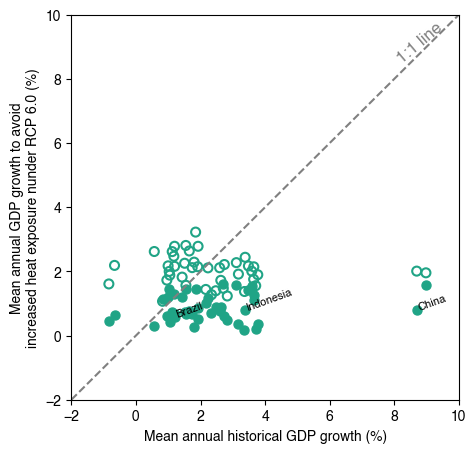

<Figure size 640x480 with 0 Axes>

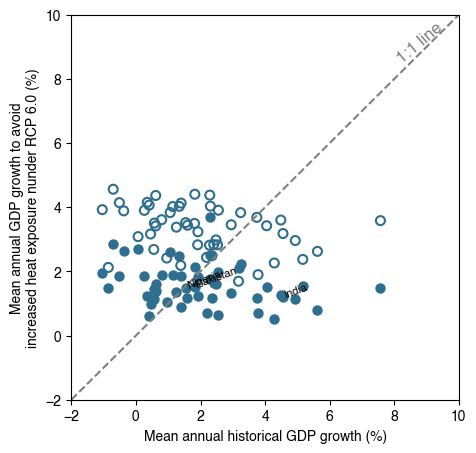

<Figure size 640x480 with 0 Axes>

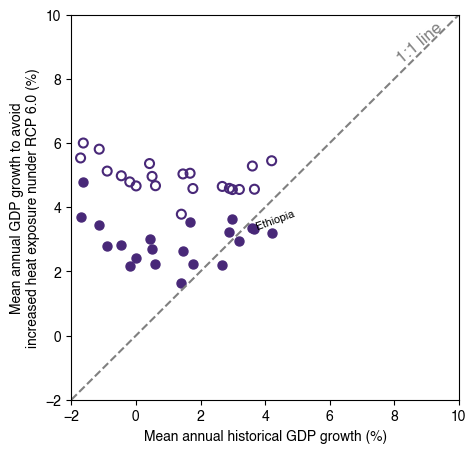

<Figure size 640x480 with 0 Axes>

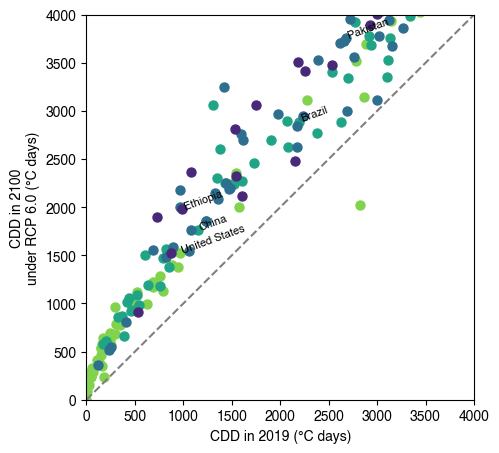

<Figure size 640x480 with 0 Axes>

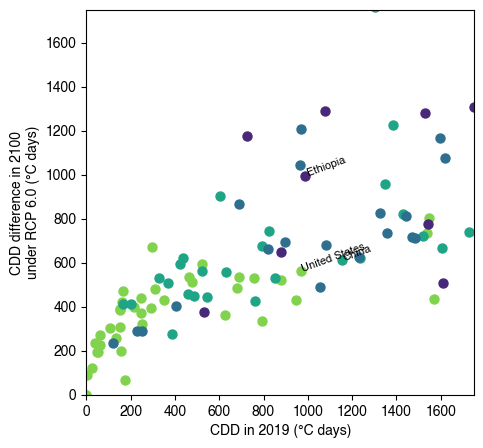

In [9]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure CDD change (Fig.3)
    if scenario == 'historical':
        scen = ''
        vars = ['CDD', 'GDP']
    else:
        scen = '_'+scenario+'_2100_diff'
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    plot_variable_histogram(config, ac_data, 'CDD'+scen)
    
    # Figure GDP and CDD maps (Fig.1)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
        # Plot maps highlighting income groups (Fig.4)
        plot_income_groups(config, ac_data)

        # Figure Contours (Fig.2)
        xrange = [config['plotting']['cdd_min'], config['plotting']['cooling_deficit_index_max'], 100]
        yrange = [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]
        # Exposure times CDD
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='exposure_contour')
        # AC adoption
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='AC_adoption_contour', multiply_cdd=False)
        continue

    # Part of Figure GDP growth (Fig.4)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)